## Initialization

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_gbq
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

In [2]:
# data visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
# PySpark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *

### Default constants

In [3]:
BUCKET_NAME = "homework_rl3154_data"
PROJECT_BUCKET = "project"
FOLDER_NAME = "forecast_data"
BIG_QUERY_TABLE_NAME = "project_dataset.agg_electricity_load_data_hourly"


### Spark initialization

In [7]:
conf = SparkConf()
conf.setMaster('yarn')
conf.setAppName("spark-bigquery-prophet")
# BigQuery Connector
conf.set("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.22.0")
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

In [8]:
sqlContext._sc.version

'3.1.2'

# Get Data

In [4]:
# Open from GCS
forecast_df = pd.read_pickle(f"gs://{BUCKET_NAME}/{PROJECT_BUCKET}/{FOLDER_NAME}/forecast_res-2021-12-09.pkl")
eval_df = pd.read_pickle(f"gs://{BUCKET_NAME}/{PROJECT_BUCKET}/{FOLDER_NAME}/forecast_eval-2021-12-09.pkl")


In [5]:
forecast_df

,ds,zone_name,y,yhat,yhat_upper,yhat_lower,trend,holidays,yearly,daily,weekly
0,2010-01-01 00:00:00,CAPITL,12518.099609,12613.607422,16561.296875,9120.713867,14812.665039,-0.095238,0.056130,-0.130641,0.021291
1,2010-01-01 01:00:00,CAPITL,13092.299805,11989.854492,15666.069336,8186.646973,14813.125000,-0.095238,0.056180,-0.172363,0.020830
2,2010-01-01 02:00:00,CAPITL,12562.200195,11588.465820,15455.477539,7901.891602,14813.585938,-0.095238,0.056229,-0.199018,0.020314
3,2010-01-01 03:00:00,CAPITL,12101.299805,11466.584961,15152.679688,7877.807129,14814.046875,-0.095238,0.056278,-0.206743,0.019738
4,2010-01-01 04:00:00,CAPITL,11989.799805,11715.201172,15239.740234,8260.172852,14814.506836,-0.095238,0.056327,-0.189391,0.019095
...,...,...,...,...,...,...,...,...,...,...,...
1148802,2021-11-30 20:00:00,MILLWD,NaN,4885.288086,6073.982422,3612.519531,4080.098145,0.000000,0.001962,0.172233,0.023151
1148803,2021-11-30 21:00:00,MILLWD,NaN,4621.094238,5895.692383,3381.287354,4080.104492,0.000000,0.002109,0.107065,0.023418
1148804,2021-11-30 22:00:00,MILLWD,NaN,4264.531250,5530.609863,2964.978516,4080.110840,0.000000,0.002257,0.019235,0.023708
1148805,2021-11-30 23:00:00,MILLWD,NaN,3896.691162,5133.661621,2598.658447,4080.117188,0.000000,0.002405,-0.071380,0.024019


In [77]:
eval_df

,training_date,zone_name,mae,mse,mape,rmse
0,2021-12-09,CAPITL,1338.881470,3.543972e+06,0.079469,1882.543945
1,2021-12-09,CENTRL,1629.996704,5.235488e+06,0.072010,2288.118896
2,2021-12-09,DUNWOD,801.376038,1.314109e+06,0.092441,1146.345947
3,2021-12-09,GENESE,1127.091919,2.572215e+06,0.080100,1603.812744
4,2021-12-09,HUD VL,1307.080322,3.498391e+06,0.093496,1870.398682
5,2021-12-09,LONGIL,3057.967041,1.947232e+07,0.100375,4412.745605
6,2021-12-09,MHK VL,874.259399,1.425834e+06,0.079860,1194.082764
7,2021-12-09,MILLWD,464.994049,4.078183e+05,0.117714,638.606567
8,2021-12-09,N.Y.C.,5754.780762,6.861935e+07,0.077383,8283.679688
9,2021-12-09,NORTH,356.260620,2.901103e+05,0.049971,538.618896


In [11]:
## Convert to Spark RDD
spark_df = sqlContext.createDataFrame(forecast_df)

# Identify Critical Dates

In [156]:
dates_df = pd.merge(
    forecast_df[(forecast_df['ds']<'2021-11-01')][['ds', 'zone_name', 'y', 'yhat']], 
    eval_df[['zone_name', 'mae', 'rmse', 'mape']], 
    on=['zone_name'], how='left'
)
dates_df['y_abs_diff'] = np.abs(dates_df['y']-dates_df['yhat'])
dates_df['y_pct_diff'] = dates_df['y_abs_diff']/dates_df['y']

dates_df

,ds,zone_name,y,yhat,mae,rmse,mape,y_abs_diff,y_pct_diff
0,2010-01-01 00:00:00,CAPITL,12518.099609,12613.607422,1338.881470,1882.543945,0.079469,95.507812,0.007630
1,2010-01-01 01:00:00,CAPITL,13092.299805,11989.854492,1338.881470,1882.543945,0.079469,1102.445312,0.084206
2,2010-01-01 02:00:00,CAPITL,12562.200195,11588.465820,1338.881470,1882.543945,0.079469,973.734375,0.077513
3,2010-01-01 03:00:00,CAPITL,12101.299805,11466.584961,1338.881470,1882.543945,0.079469,634.714844,0.052450
4,2010-01-01 04:00:00,CAPITL,11989.799805,11715.201172,1338.881470,1882.543945,0.079469,274.598633,0.022903
...,...,...,...,...,...,...,...,...,...
1140871,2021-10-31 19:00:00,MILLWD,3901.063965,4167.789062,464.994049,638.606567,0.117714,266.725098,0.068372
1140872,2021-10-31 20:00:00,MILLWD,3805.951416,4060.871826,464.994049,638.606567,0.117714,254.920410,0.066979
1140873,2021-10-31 21:00:00,MILLWD,3647.767578,3807.325439,464.994049,638.606567,0.117714,159.557861,0.043741
1140874,2021-10-31 22:00:00,MILLWD,3449.541748,3461.595947,464.994049,638.606567,0.117714,12.054199,0.003494


## Based on RMSE

In [175]:
filtered_dates = (dates_df[(dates_df['y_abs_diff']>(5*dates_df['rmse']))]
                  .groupby(['zone_name', dates_df['ds'].dt.date])
                  .agg(anomaly_occurence=('ds', 'nunique'))
                  .reset_index())
filtered_dates = filtered_dates[filtered_dates['anomaly_occurence']>3]
filtered_dates#.describe()

,zone_name,ds,anomaly_occurence
7,CAPITL,2011-07-21,4
8,CAPITL,2011-07-22,5
14,CAPITL,2012-06-20,5
15,CAPITL,2012-06-21,6
46,CAPITL,2013-07-18,5
...,...,...,...
1954,WEST,2013-09-11,6
2028,WEST,2016-08-12,4
2071,WEST,2019-06-28,4
2073,WEST,2019-07-02,4


In [180]:
filtered_dates.to_csv(f"gs://{BUCKET_NAME}/{PROJECT_BUCKET}/{FOLDER_NAME}/dates_for_twitter.csv", index=False)

In [178]:
# Summary
pd.merge(
    filtered_dates.groupby('zone_name').agg(unique_date=('ds','nunique')).reset_index(), 
    filtered_dates.groupby('zone_name')['ds'].apply(list).reset_index(),
    how='left',
    on=['zone_name']
)

,zone_name,unique_date,ds
0,CAPITL,11,"[2011-07-21, 2011-07-22, 2012-06-20, 2012-06-2..."
1,CENTRL,8,"[2011-07-21, 2011-07-22, 2012-06-20, 2012-06-2..."
2,DUNWOD,16,"[2011-07-22, 2012-06-21, 2012-06-29, 2013-05-3..."
3,GENESE,13,"[2011-07-21, 2011-07-22, 2012-06-20, 2012-06-2..."
4,HUD VL,15,"[2011-06-09, 2011-07-21, 2011-07-22, 2012-06-2..."
5,LONGIL,13,"[2011-07-22, 2012-06-21, 2012-06-29, 2012-07-0..."
6,MHK VL,5,"[2011-07-21, 2011-07-22, 2012-06-21, 2012-06-2..."
7,MILLWD,9,"[2011-06-08, 2011-06-09, 2011-07-22, 2012-06-2..."
8,N.Y.C.,14,"[2011-07-22, 2012-06-21, 2012-06-29, 2013-05-3..."
9,NORTH,5,"[2012-06-21, 2012-10-31, 2014-01-03, 2014-02-2..."


# Plot Components

In [39]:
test_df = forecast_df[(forecast_df['zone_name']=='N.Y.C.')].dropna().reset_index(drop=True)

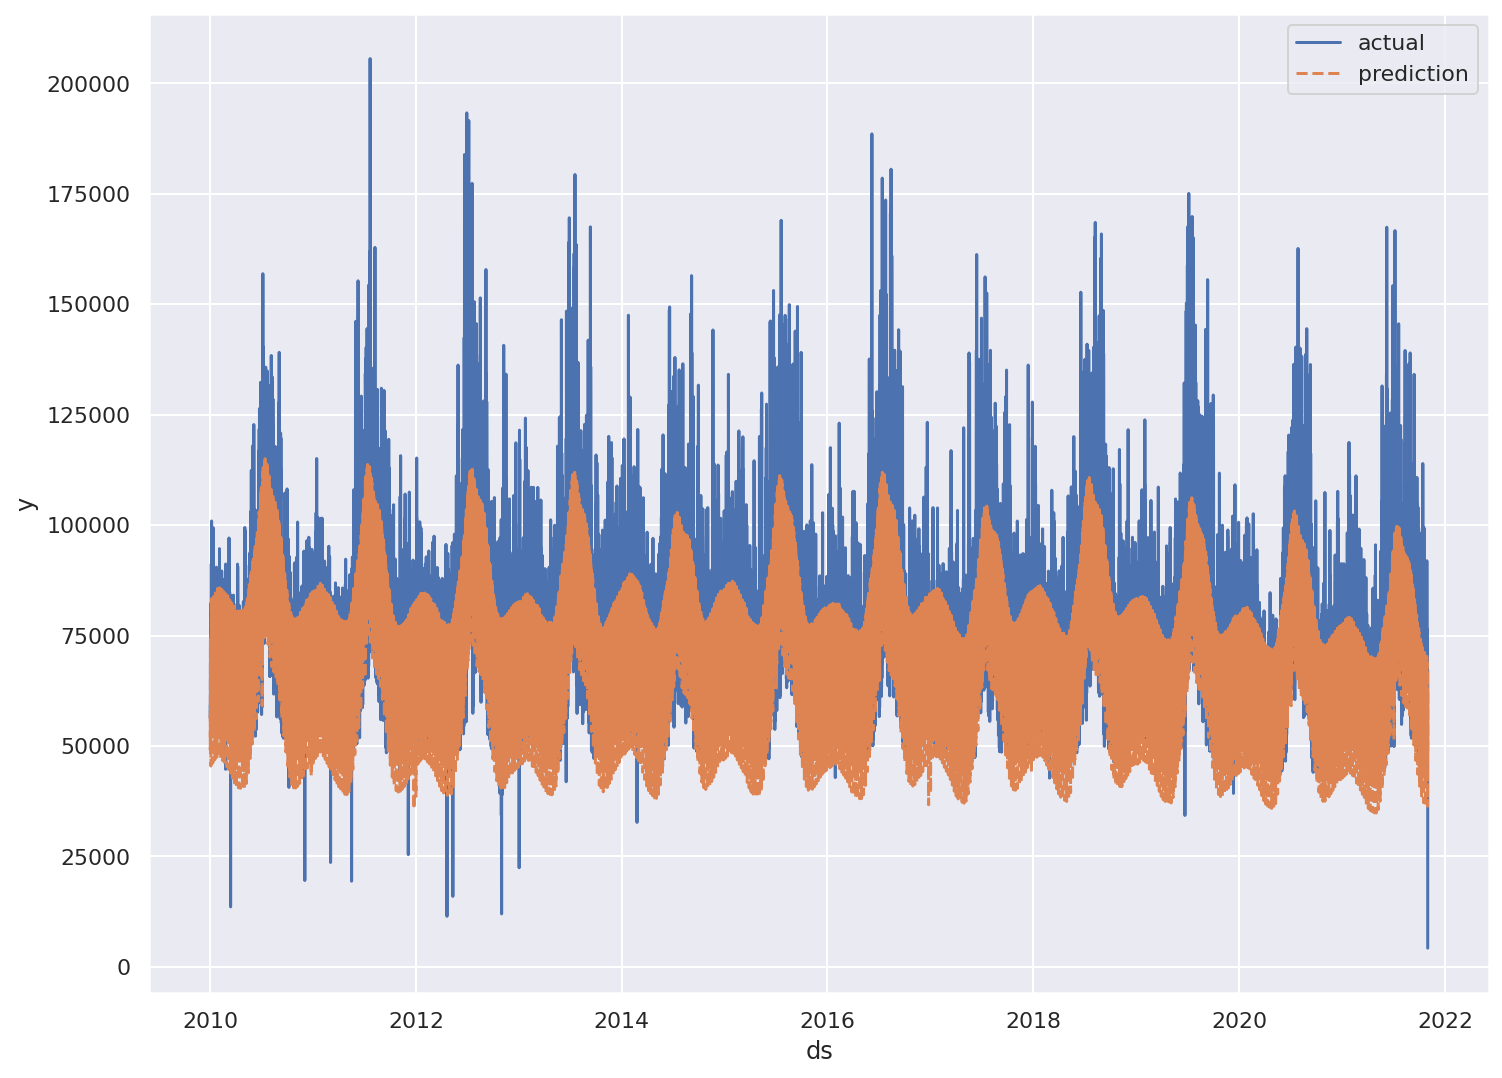

In [40]:
# Columns ds, y, yhat, yhat_upper, yhat_lower

plot_df = test_df[['ds', 'y', 'yhat']]

plt.figure(figsize=(12,9))
sns.lineplot(data=plot_df, x='ds', y='y', label='actual')
sns.lineplot(data=plot_df, x='ds', y='yhat', linestyle='--', label='prediction')

<AxesSubplot:xlabel='ds', ylabel='trend'>

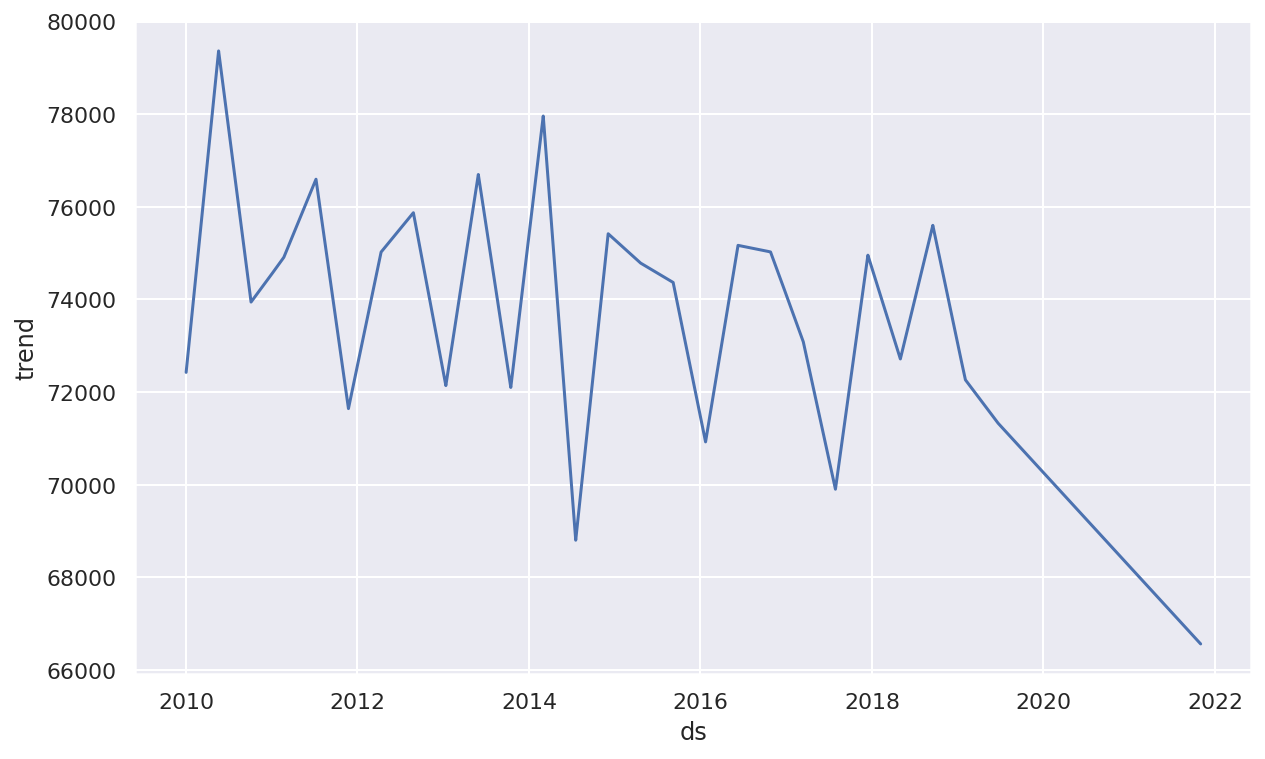

In [41]:
# Columns ds, trend

plot_df = test_df[['ds', 'trend']]

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='ds', y='trend')

<AxesSubplot:xlabel='ds', ylabel='holidays'>

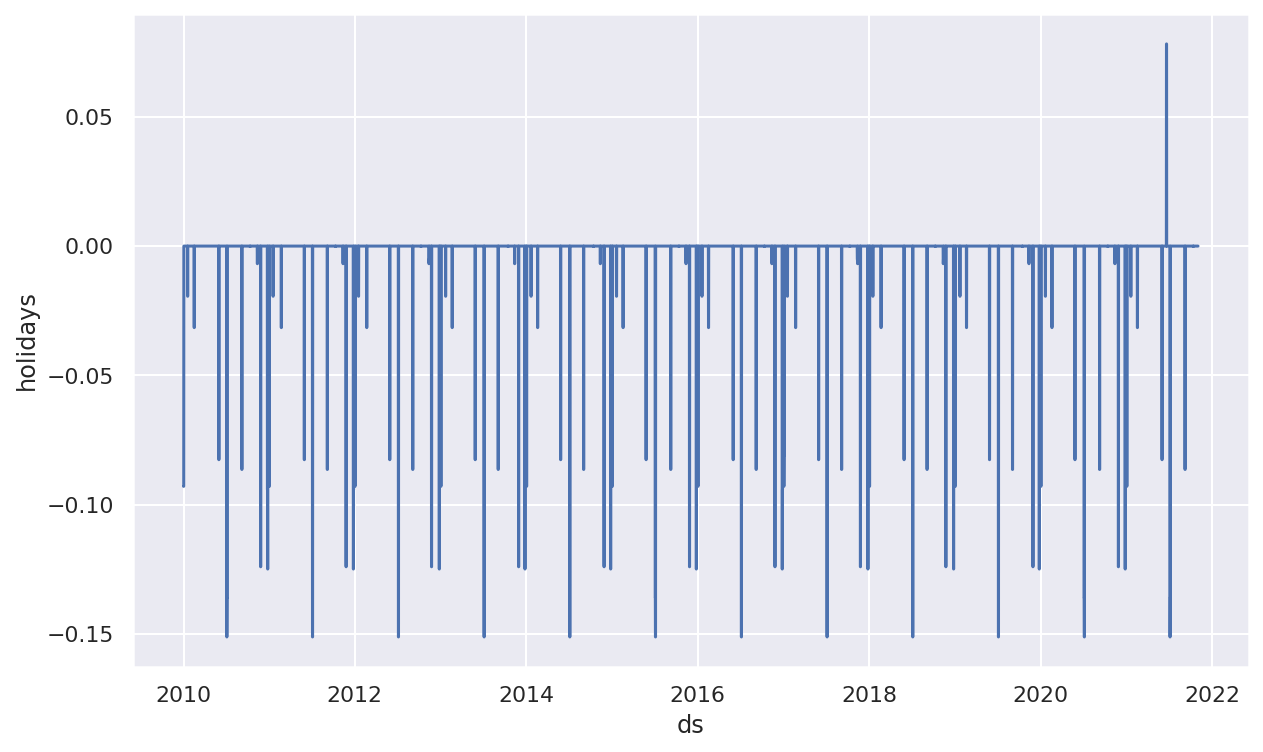

In [42]:
# Columns ds, holidays
plot_df = test_df[['ds', 'holidays']]

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='ds', y='holidays')

<AxesSubplot:xlabel='month', ylabel='yearly'>

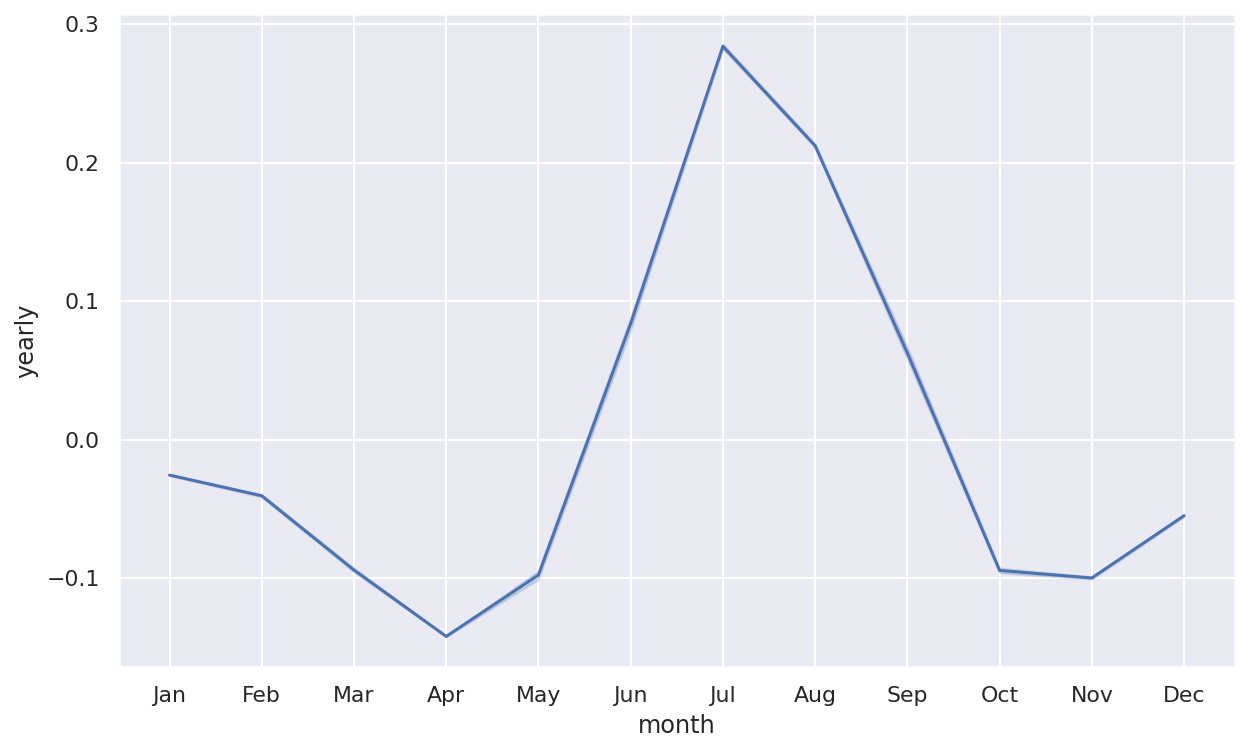

In [43]:
# Columns ds, yearly
plot_df = test_df[['ds', 'yearly']]
plot_df = plot_df[(plot_df['ds']<str(plot_df['ds'].min().year+1))]
plot_df['month'] = plot_df['ds'].dt.strftime('%b')

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='month', y='yearly')

<AxesSubplot:xlabel='hour', ylabel='daily'>

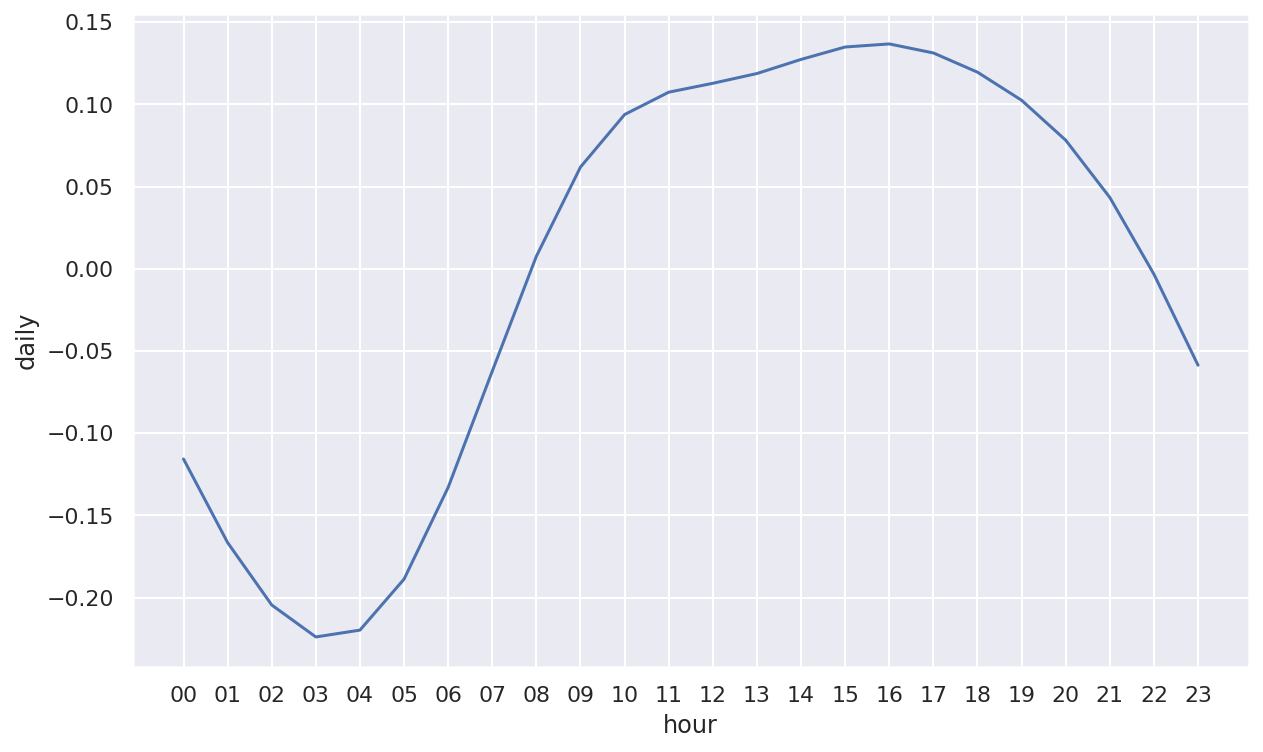

In [44]:
# Columns ds, daily
plot_df = test_df[['ds', 'daily']]
plot_df = plot_df[:24]
plot_df['hour'] = plot_df['ds'].dt.strftime('%H')

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='hour', y='daily')

<AxesSubplot:xlabel='day_of_week', ylabel='weekly'>

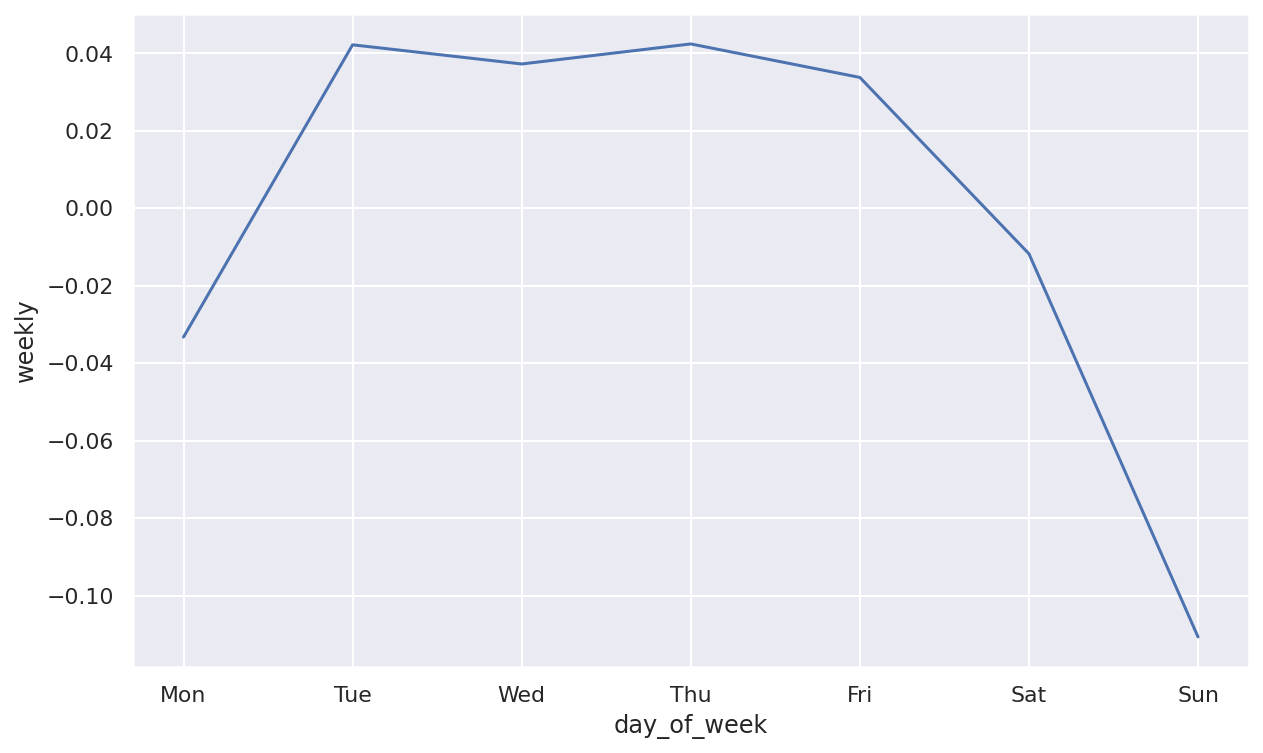

In [63]:
# Columns ds, weekly
plot_df = test_df[['ds', 'weekly']]
plot_df = plot_df[:24*7:24]
plot_df['day_of_week'] = plot_df['ds'].dt.strftime('%a')
plot_df['num_day'] = plot_df['ds'].dt.dayofweek
plot_df = plot_df.sort_values(by='num_day')

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='day_of_week', y='weekly')

In [27]:
eval_df

,training_date,zone_name,mae,mse,mape,rmse
0,2021-12-09,CAPITL,1338.881470,3.543972e+06,0.079469,1882.543945
1,2021-12-09,CENTRL,1629.996704,5.235488e+06,0.072010,2288.118896
2,2021-12-09,DUNWOD,801.376038,1.314109e+06,0.092441,1146.345947
3,2021-12-09,GENESE,1127.091919,2.572215e+06,0.080100,1603.812744
4,2021-12-09,HUD VL,1307.080322,3.498391e+06,0.093496,1870.398682
5,2021-12-09,LONGIL,3057.967041,1.947232e+07,0.100375,4412.745605
6,2021-12-09,MHK VL,874.259399,1.425834e+06,0.079860,1194.082764
7,2021-12-09,MILLWD,464.994049,4.078183e+05,0.117714,638.606567
8,2021-12-09,N.Y.C.,5754.780762,6.861935e+07,0.077383,8283.679688
9,2021-12-09,NORTH,356.260620,2.901103e+05,0.049971,538.618896


# Unused Trial

In [ ]:
saved = defaultdict(list)

# for zone in tqdm(load_df['zone_name'].unique()):
for zone in tqdm(['N.Y.C.']):
    prophet_df = load_df[(load_df['zone_name']==zone)]
    
    f_pd = forecast_load(prophet_df)
    
    e_pd = evaluate_forecast(f_pd)
    
    saved['zone'].append(zone)
    saved['forecast'].append(f_pd)
    saved['evaluation'].append(e_pd)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
saved = defaultdict(list)

for zone in tqdm(load_df['zone_name'].unique()):
    prophet_df = load_df[(load_df['zone_name']==zone)]
    
    f_pd = forecast_load(prophet_df)
    
    #test_df = pd.merge(f_pd, prophet_df, how='left', on=['ds']).dropna()
    test_df = f_pd.dropna()
    
    mae = mean_absolute_error(test_df['y'], test_df['yhat'])
    mape = mean_absolute_percentage_error(test_df['y'], test_df['yhat'])
    rmse = np.sqrt(mean_squared_error(test_df['y'], test_df['yhat']))
    
    saved['zone'].append(zone)
    saved['forecast'].append(f_pd)
    saved['evaluation'].append({'mae': mae, 'mape': mape, 'rmse': rmse,})

  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -47.1788
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       46482.5    0.00516332       863.784           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       46683.4    0.00199977       2439.66           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         46915    0.00175028       4301.66       0.313           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       47011.4     0.0134618       3405.77           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       47099.2     0.0127681        2354.3           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

  9%|▉         | 1/11 [01:23<13:59, 83.96s/it]

Initial log joint probability = -75.9994
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       48974.1     0.0028218       2260.46      0.4577           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       49026.8    0.00505012       1842.57           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       49098.6     0.0082838       776.808      0.3487           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       49109.3    0.00635031       504.888      0.5276      0.5276      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         49155    0.00253574       1323.17           1           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha  

 18%|█▊        | 2/11 [02:34<11:22, 75.85s/it]

Initial log joint probability = -60.5282
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       45334.9     0.0490777        5115.2           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       45514.7     0.0203672       7168.99           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       45744.2    0.00320578       1188.41           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       45791.2    0.00540752        1746.5           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       45839.4    0.00994345       1502.98      0.1129           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

 27%|██▋       | 3/11 [03:53<10:21, 77.66s/it]

Initial log joint probability = -61.281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       44583.8     0.0082521       1359.57        2.46       0.246      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       44781.7     0.0203106       2909.67           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       44964.1     0.0142225       796.588           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       44987.8     0.0107378       1057.82       1.063      0.1063      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       45021.8     0.0208608       1405.33           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha   

 36%|███▋      | 4/11 [05:24<09:40, 82.86s/it]

Initial log joint probability = -82.4023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       44681.7     0.0102279       2396.02           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       45057.8     0.0272941       5880.75      0.5243           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       45166.1      0.022358       1629.63           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       45186.9    0.00861556       1064.56      0.2339           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       45242.9      0.023454       1576.09        1.03       0.103      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

 45%|████▌     | 5/11 [07:00<08:44, 87.43s/it]

Initial log joint probability = -68.113
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         44687    0.00558516       1330.42      0.7063      0.7063      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       44924.3     0.0552782       1908.97           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       45037.3    0.00243177       1013.45      0.2979      0.2979      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       45079.4     0.0011093       634.966           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       45142.1     0.0127579       1395.37        0.43           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha   

 55%|█████▍    | 6/11 [08:30<07:21, 88.23s/it]

Initial log joint probability = -71.1386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       44054.3     0.0340327       5124.41           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       44505.6     0.0144016        2096.1      0.9355      0.9355      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       44615.1    0.00727408       1754.17           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       44676.2     0.0248238       1551.06           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       44726.6     0.0055259       2818.93           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

 64%|██████▎   | 7/11 [10:37<06:43, 100.97s/it]

Initial log joint probability = -90.4633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       45158.5      0.296685       25961.9           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       45553.8     0.0356158       3196.95           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       45697.8     0.0119652       1916.94           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       45770.5   0.000676911       947.424      0.8362      0.8362      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       45798.4    0.00900742       698.954           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

 73%|███████▎  | 8/11 [12:45<05:28, 109.49s/it]

Initial log joint probability = -69.9239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       44436.1     0.0189821       4521.92           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       44517.5    0.00114416       515.403           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         44706    0.00477502       511.188           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       44768.8    0.00399333        2165.4      0.8031      0.8031      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         44819    0.00215976       1306.26        0.51        0.51      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

 82%|████████▏ | 9/11 [14:38<03:41, 110.88s/it]

Initial log joint probability = -90.1306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       41824.4     0.0122805       3919.78           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       42214.9     0.0197753       1215.97           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       42279.3    0.00194303       757.379           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       42341.9     0.0178538       1264.27           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       42444.3       0.34062       11156.5           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

 91%|█████████ | 10/11 [17:01<02:00, 120.58s/it]

Initial log joint probability = -81.6551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       46526.6   0.000641103       2276.19      0.0876      0.8887      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       46824.7    0.00285625       2799.39      0.6593      0.6593      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         46891    0.00119242       1481.71           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       46926.2    0.00159678       1296.57      0.3453      0.3453      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       46977.9     0.0333634       1495.56           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha  

100%|██████████| 11/11 [18:25<00:00, 100.47s/it]


In [35]:
saved['evaluation']

[{'mae': 1284.3853701992482,
  'mape': 0.060714567249601226,
  'rmse': 1862.2421527762733},
 {'mae': 350.84590437604226,
  'mape': 0.04948693930555864,
  'rmse': 523.600238640994},
 {'mae': 1222.5743651348118,
  'mape': 0.07221735463333151,
  'rmse': 1706.6240973270715},
 {'mae': 1518.0724726614644,
  'mape': 0.06810277079882258,
  'rmse': 2126.0799030935673},
 {'mae': 678.1890486875235,
  'mape': 0.07938104352201195,
  'rmse': 983.5570793034544},
 {'mae': 999.0420234941151,
  'mape': 0.07131611669431416,
  'rmse': 1433.5855617246993},
 {'mae': 1151.8971970581028,
  'mape': 0.08568505652209056,
  'rmse': 1611.5341857438718},
 {'mae': 2630.1009397596995,
  'mape': 0.08911784911988736,
  'rmse': 3766.0793303888445},
 {'mae': 799.2640468558999,
  'mape': 0.07326143249024106,
  'rmse': 1092.7458402790805},
 {'mae': 392.50607946262096,
  'mape': 0.09833030660639705,
  'rmse': 542.213349599142},
 {'mae': 4918.727582557314,
  'mape': 0.0676828605822205,
  'rmse': 7194.507773635305}]

In [12]:
f_pd = forecast_load(prophet_df)

Initial log joint probability = -47.1788
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       46482.5    0.00516332       863.784           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       46683.4    0.00199977       2439.66           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         46915    0.00175028       4301.66       0.313           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       47011.4     0.0134618       3405.77           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       47099.2     0.0127681        2354.3           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [22]:
test_df = pd.merge(f_pd, prophet_df, how='left', on=['ds']).dropna()

In [23]:
mean_absolute_error(test_df['y'], test_df['yhat'])

1284.3853701992482

In [24]:
mean_absolute_percentage_error(test_df['y'], test_df['yhat'])

0.060714567249601226

In [25]:
np.sqrt(mean_squared_error(test_df['y'], test_df['yhat']))

1862.2421527762733

In [ ]:
# logging var
models = defaultdict(list)

# for zone in ['N.Y.C.']:
for zone in load_df['zone_name'].unique():
    temp_df = load_df[(load_df['zone_name']==zone)]
    prophet_df = pd.DataFrame({
        "ds": temp_df['timestamp'],
        "y": temp_df['sum_rtd_actual_load'],
    })
    
    m = Prophet(changepoint_prior_scale=0.01)
    m.fit(prophet_df)
    
    future = m.make_future_dataframe(periods=24*30, freq='H')
    forecast = m.predict(future)
    
    #df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
    #df_cv = cross_validation(m, initial='12000 hours', period='3600 hours', horizon = '168 hours')
    #df_p = performance_metrics(df_cv)
    
    models['zone'].append(zone)
    models['model'].append(m)
    models['data'].append(prophet_df)
    #models['forecast'].append(forecast)
    #models['perf'].append(df_p)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [9]:
models['perf'][0]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.391696e+10,184165.589601,134995.703975,0.076799,0.055001,0.074721,0.729072
1,38 days,3.437400e+10,185402.252323,136120.198654,0.077057,0.054943,0.074993,0.726788
2,39 days,3.457044e+10,185931.282434,136510.614150,0.076914,0.054943,0.074863,0.725266
3,40 days,3.452023e+10,185796.207019,136263.012665,0.076602,0.054023,0.074534,0.726027
4,41 days,3.445855e+10,185630.134162,136835.015313,0.076820,0.054009,0.074672,0.722983
...,...,...,...,...,...,...,...,...
324,361 days,1.999348e+10,141398.299110,103906.112461,0.067212,0.051720,0.066057,0.849315
325,362 days,2.016038e+10,141987.263324,104608.881756,0.067754,0.051765,0.066471,0.847032
326,363 days,2.025486e+10,142319.572680,105576.657825,0.068438,0.053132,0.067058,0.844749
327,364 days,2.015914e+10,141982.900350,105892.934642,0.068687,0.054112,0.067257,0.846271


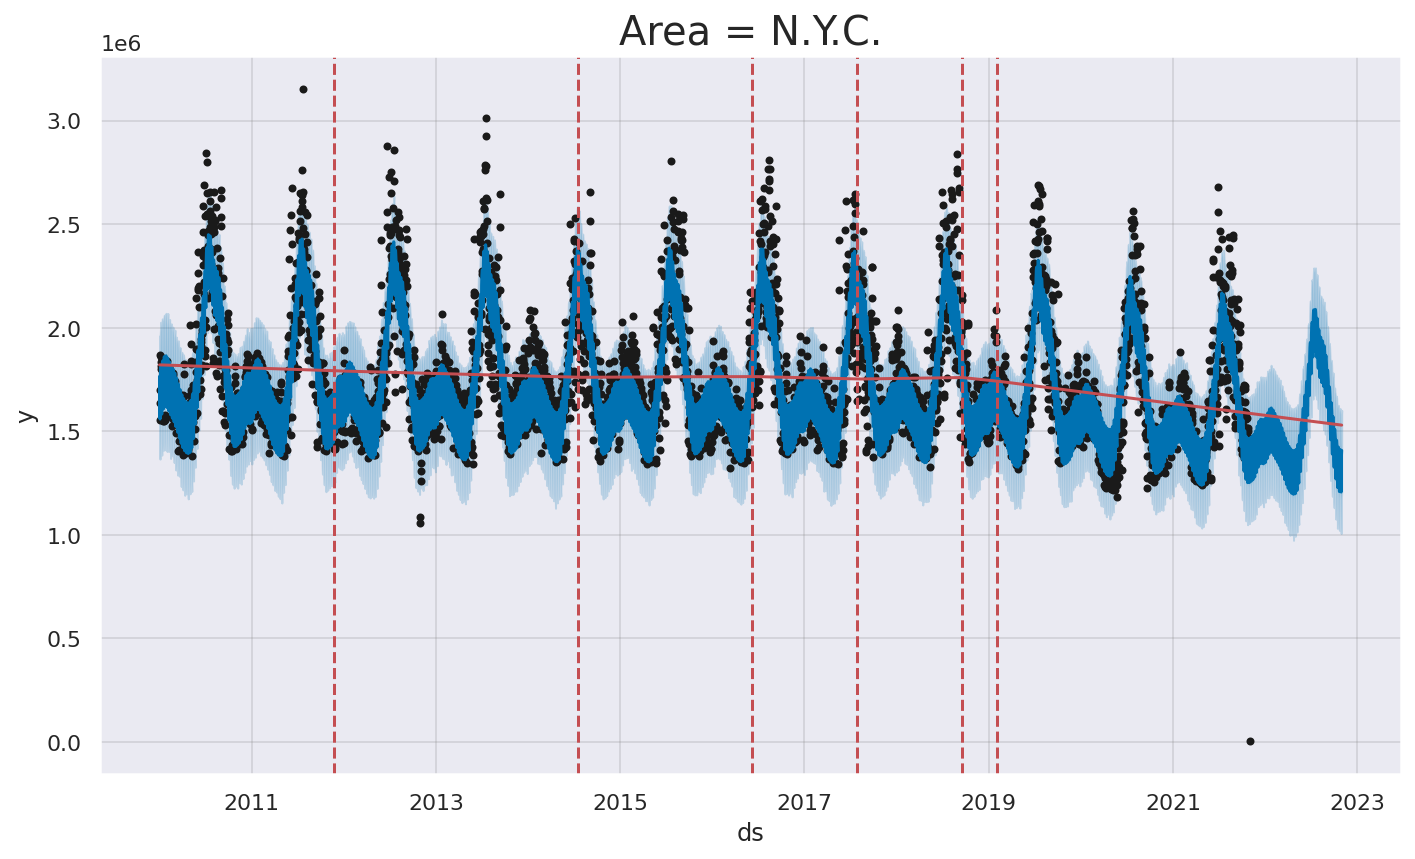

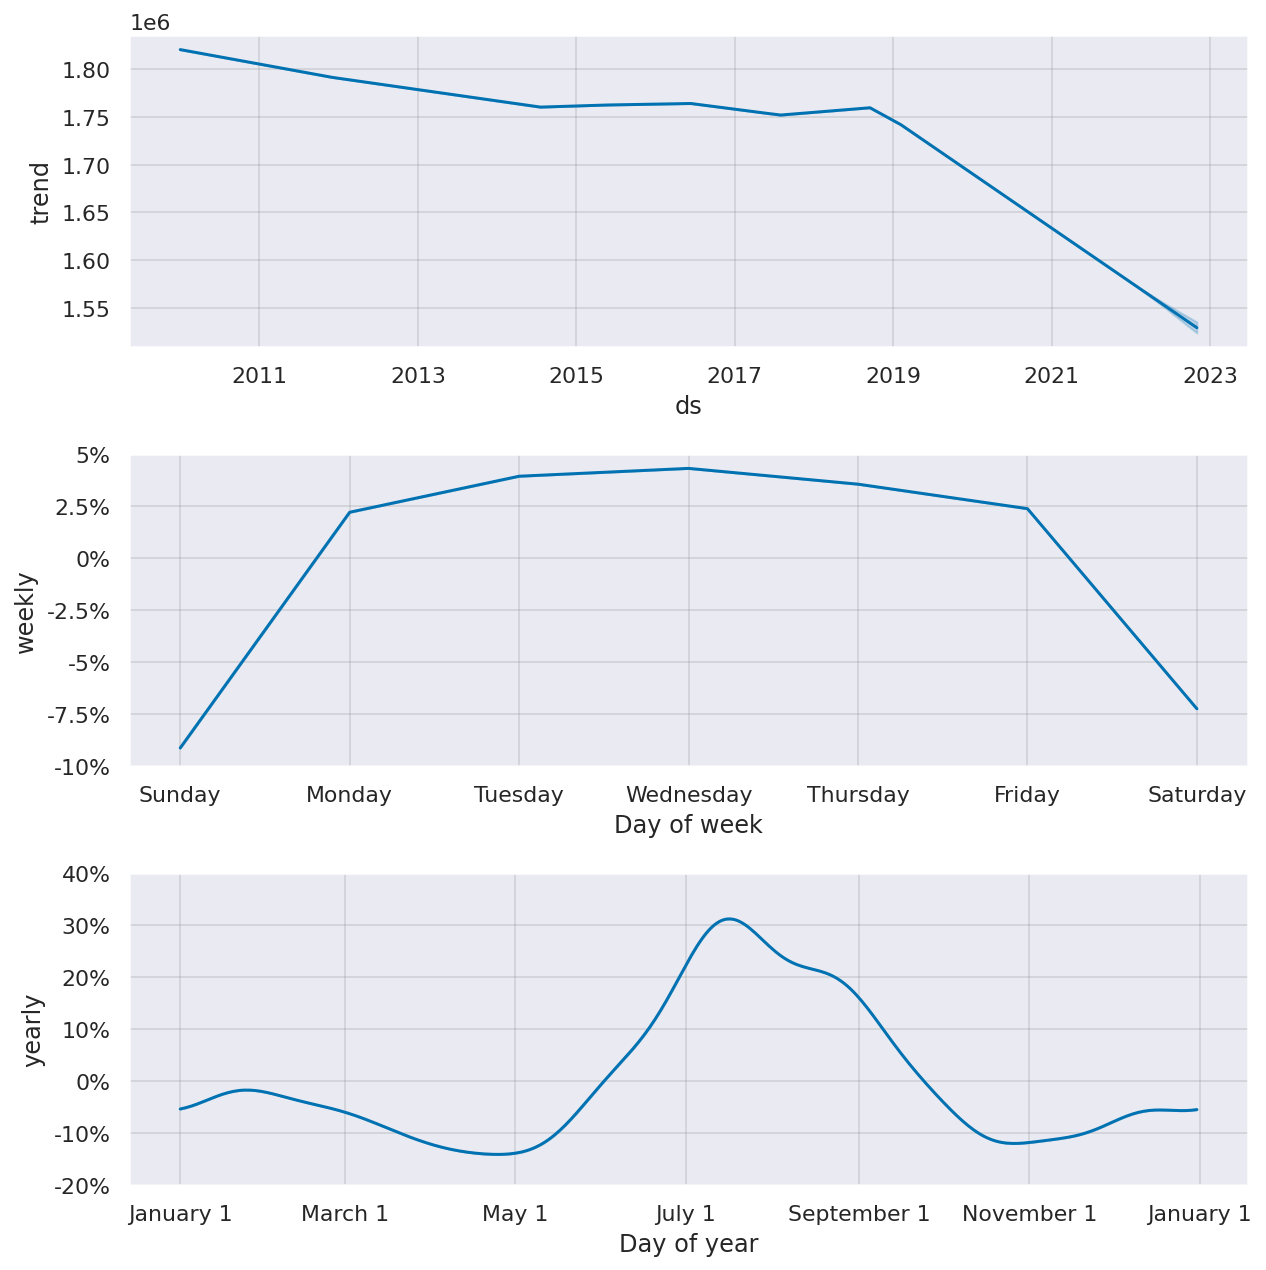

In [10]:
for i in range(len(models['zone'])):
    mymodel = models['model'][i]
    myforecast = models['forecast'][i]
    
    fig = mymodel.plot(myforecast)
    ax = fig.gca()
    a = add_changepoints_to_plot(ax, mymodel, forecast)
    ax.set_title(f"Area = {models['zone'][i]}", size=20)
    
    fig = mymodel.plot_components(myforecast)

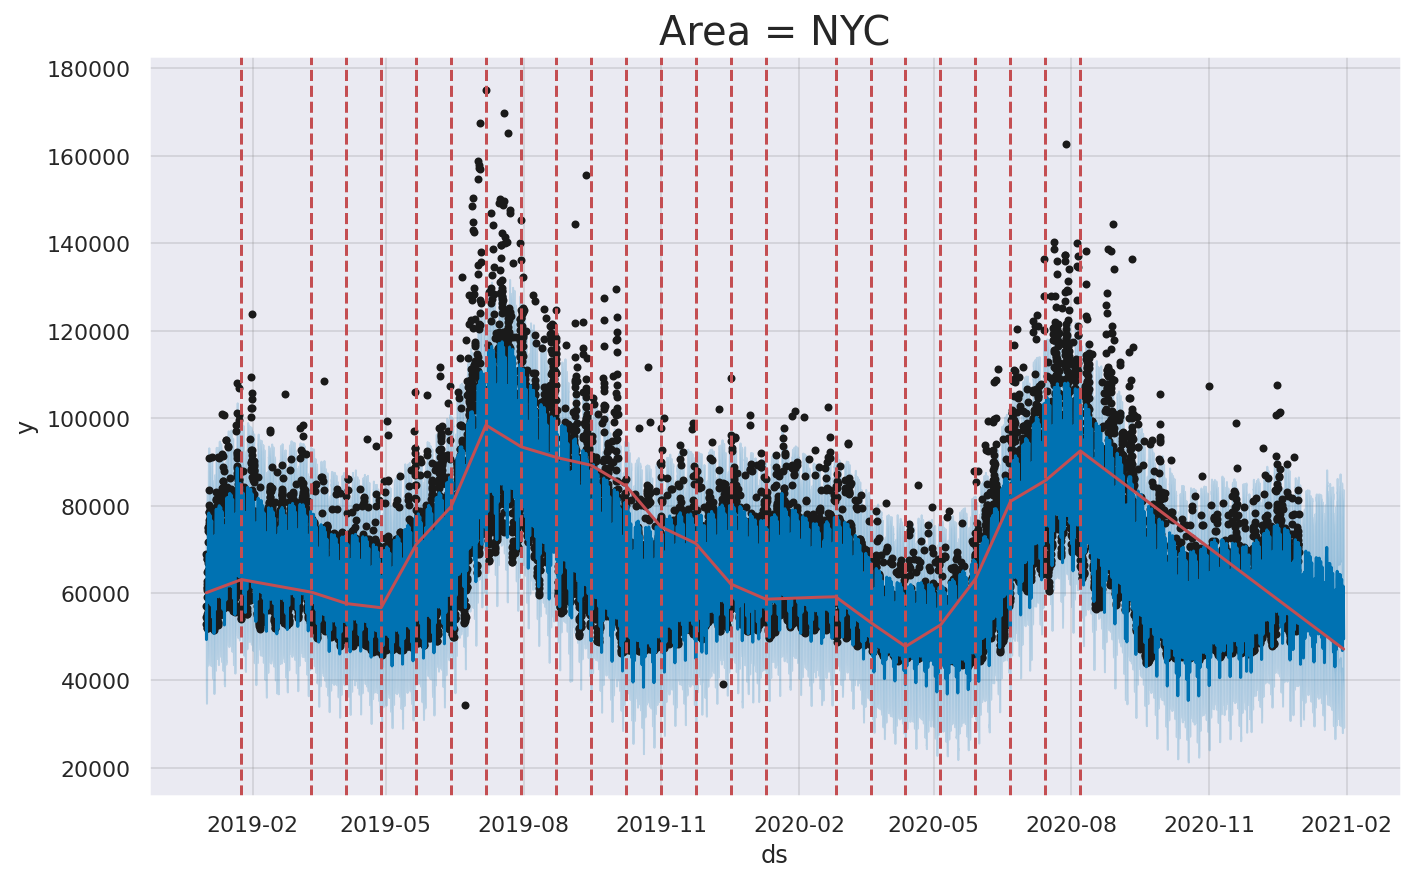

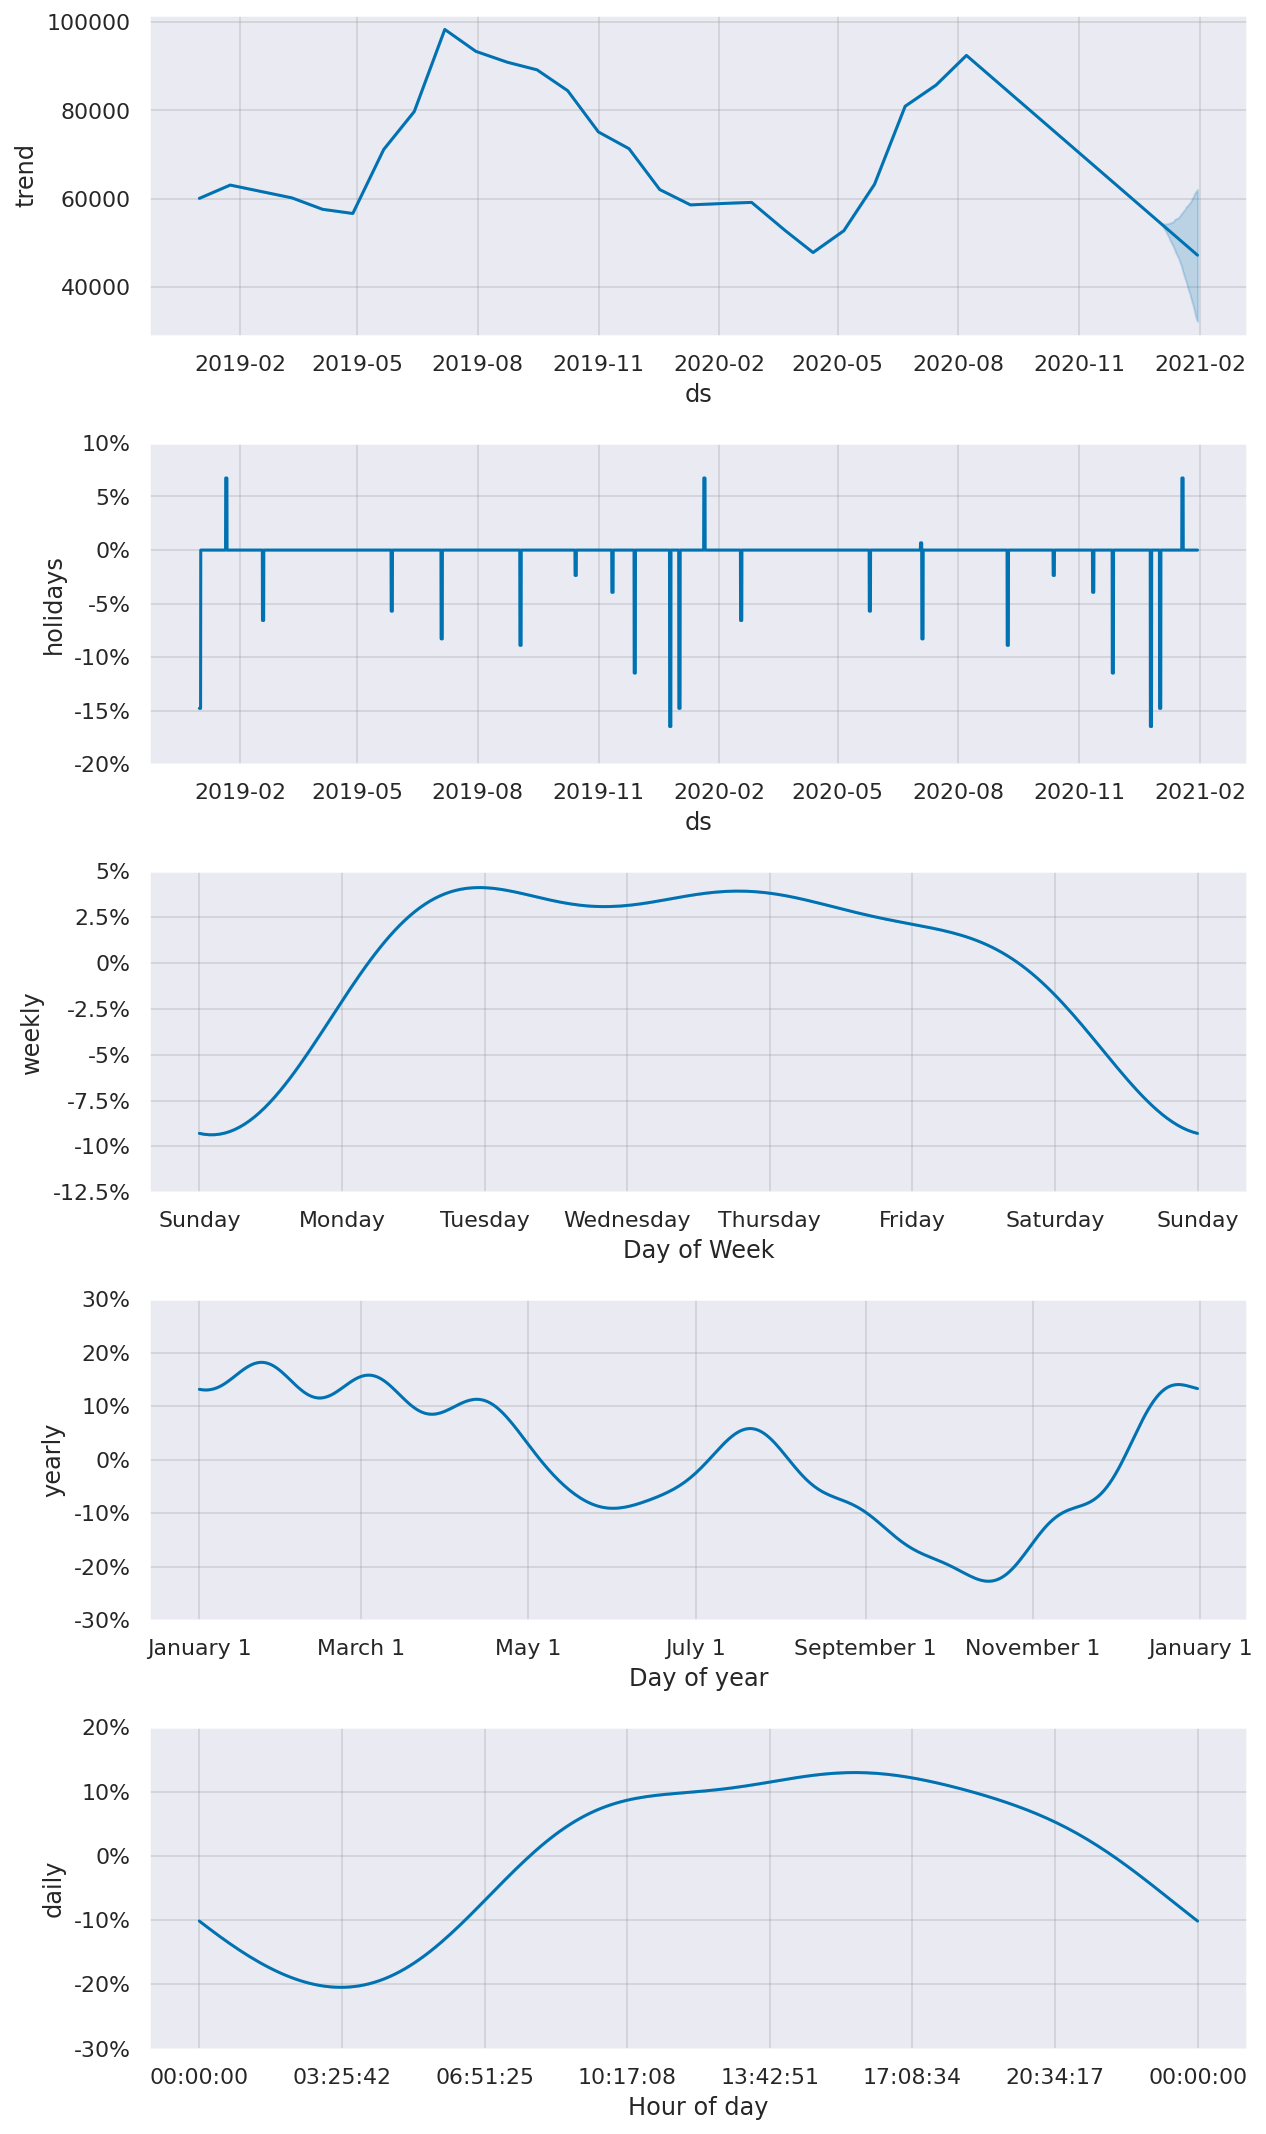

In [18]:
mymodel = m
myforecast = forecast

fig = mymodel.plot(myforecast)
ax = fig.gca()
a = add_changepoints_to_plot(ax, mymodel, forecast)
ax.set_title("Area = NYC", size=20)

fig = mymodel.plot_components(myforecast)